# Introduction

As an example of simple logistic regression, we will work with data collected by Suzuki et al. (2006). They measured sand grain size on 28 beaches in Japan and observed the presence or absence of the burrowing wolf spider *Lycosa ishikariana* on each beach. 



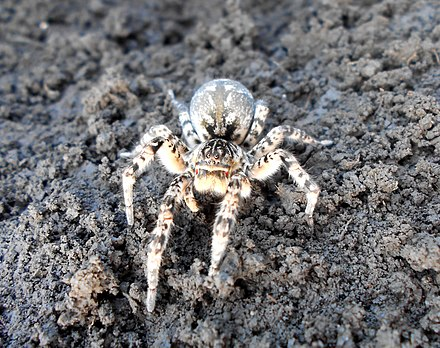

Sand grain size is a measurement variable, and spider presence or absence is a nominal variable. Spider presence or absence is the dependent variable; if there is a relationship between the two variables, it would be sand grain size affecting spiders, not the presence of spiders affecting the sand.

One goal of this study would be to determine whether there was a relationship between sand grain size and the presence or absence of the species, in hopes of understanding more about the biology of the spiders. 

Because this species is endangered, another goal would be to find an equation that would predict the probability of a wolf spider population surviving on a beach with a particular sand grain size, to help determine which beaches to reintroduce the spider to.

# Simple logistic regression

In [ ]:
%matplotlib inline

In [ ]:
import io
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats
import scipy.special
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook')
import warnings
warnings.filterwarnings('ignore')


We construct a table from collected experimental data:

In [ ]:
data = """Grain size (mm)	Spiders
0.245	absent
0.247	absent
0.285	present
0.299	present
0.327	present
0.347	present
0.356	absent
0.36	present
0.363	absent
0.364	present
0.398	absent
0.4	present
0.409	absent
0.421	present
0.432	absent
0.473	present
0.509	present
0.529	present
0.561	absent
0.569	absent
0.594	present
0.638	present
0.656	present
0.816	present
0.853	present
0.938	present
1.036	present
1.045	present
"""
df = pd.read_table(io.StringIO(data))
df.Spiders = df.Spiders == 'present'
df.head()

,Grain size (mm),Spiders
0,0.245,False
1,0.247,False
2,0.285,True
3,0.299,True
4,0.327,True


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Grain size (mm)  28 non-null     float64
 1   Spiders          28 non-null     bool   
dtypes: bool(1), float64(1)
memory usage: 380.0 bytes


We will analyse this with the *scikit-learn* package.

In [ ]:
import sklearn.linear_model
import sklearn.metrics

scikit-learn has a logisitic regression classifier which uses regularization. To eliminate regularization, we set the regularization parameter `C` to $10^{12}$.

In [ ]:
# C=1e12 is effectively no regularization - see https://github.com/scikit-learn/scikit-learn/issues/6738
clf = sklearn.linear_model.LogisticRegression(C=1e12, random_state=0)
clf.fit(df['Grain size (mm)'].values.reshape(-1, 1), df['Spiders'])
print(clf.intercept_, clf.coef_)

[-1.64761964] [[5.12153717]]


Thus, we obtain the following equation:
$$
probability of spider presence = \frac{e^{-1.6476+5.1215(grain \; size)}}{(1+e^{-1.6476+5.1215(grain \; size)}}
$$

In [ ]:
def plot_log_reg(x, y, data, clf, xmin=None, xmax=None, alpha=1, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure
    ax.scatter(data[x], data[y], color='black', zorder=20, alpha=alpha)
    if xmin is None:
        xmin = x.min()
    if xmax is None:
        xmax = x.max()
    X_test = np.linspace(xmin, xmax, 300)

    loss = scipy.special.expit(X_test * clf.coef_ + clf.intercept_).ravel()
    ax.plot(X_test, loss, linewidth=3)

    ax.set_xlabel(x)
    ax.set_ylabel(y)
    fig.tight_layout()
    sns.despine()
    return fig, ax

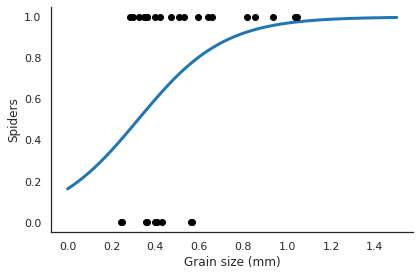

In [ ]:
plot_log_reg(x='Grain size (mm)', y='Spiders', data=df, clf=clf, xmin=0, xmax=1.5);

# Hypothesis testing

To test if *Grain size* is a significant factor, we use the likelihood ratio test. 


We calculate the likelihood of the model with the grain size (the alternative model):

In [ ]:
def log_reg_null_model(y):
    clf = sklearn.linear_model.LogisticRegression(C=1e12)
    clf.fit(np.zeros_like(y).reshape(-1, 1), y)
    return clf

clf0 = log_reg_null_model(df['Spiders'])

The likelihood ratio test operates by calculating the test statistic $D$ from the likelihoods of the null and alternative models:
$$
D = -2 \log{ \frac{L(H_0)}{L(H_1)} }
$$
The test statistic is then approximately chisquare distributed.

*scikit-learn* has a log-loss function that can help us do that. 
The log-loss is defined as the negative log-likelihood, so we can rewrite:
$$
D = 2 (-\log{L(H_0)} + \log{L(H_1)}) \Rightarrow \\
D = 2 (logloss(H_0) - logloss(H_1))
$$

In [ ]:
def log_reg_lik_ratio_test(X, Y, clf0, clf1, df=1):
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    y_prob0 = clf0.predict_proba(X)
    loss0 = sklearn.metrics.log_loss(Y, y_prob0, normalize=False)
    y_prob1 = clf1.predict_proba(X)
    loss1 = sklearn.metrics.log_loss(Y, y_prob1, normalize=False)
    D = 2 * (loss0 - loss1)
    return scipy.stats.distributions.chi2.sf(D, df=df)

In [ ]:
log_reg_lik_ratio_test(df['Grain size (mm)'].values.reshape(-1, 1), df['Spiders'].astype(np.float64), clf0, clf)

0.033243766809119446

The P value using the likelihood ratio method is 0.033, so we would reject the null hypothesis. e.g. that the Grain size is actually a significant factor.

In [ ]:
# Printing the probabilities
df

,Grain size (mm),Spiders
0,0.245,False
1,0.247,False
2,0.285,True
3,0.299,True
4,0.327,True
5,0.347,True
6,0.356,False
7,0.360,True
8,0.363,False
9,0.364,True


We can see for each case whether there probability of spider presence is True or False and we can compare them to the values in a range from 0 to 1. 

**What differences can you tell?**

**Multinomial logistic regression using Scikit-Learn**


In [ ]:
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [ ]:
#digits dataset: https://archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits

In [ ]:
# Loading the dataset
digits = datasets.load_digits()


Now that we have the dataset loaded we can do some exploration

In [ ]:
# Print to show there are 1797 images (8 by 8 images for a dimensionality of 64)
print("Image Data Shape" , digits.data.shape)

# Print to show there are 1797 labels (integers from 0-9)
print("Label Data Shape", digits.target.shape)

Image Data Shape (1797, 64)
Label Data Shape (1797,)


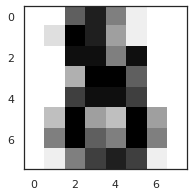

In [ ]:
#Display the first digit
plt.figure(1, figsize=(3, 3))
plt.imshow(digits.images[-1], cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

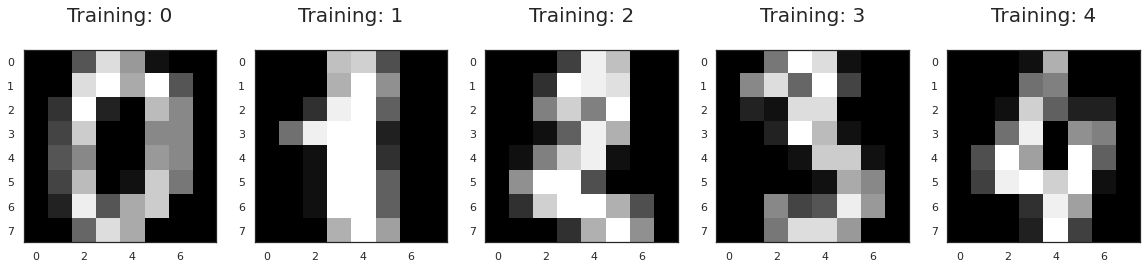

In [ ]:
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(digits.data[0:5], digits.target[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % label, fontsize = 20)

**Splitting Data into Training and Test Sets (Digits Dataset)**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.20, random_state=0)


In [ ]:
X_train.shape , X_test.shape , y_train.shape , y_test.shape

((1437, 64), (360, 64), (1437,), (360,))

In [ ]:
# Apply logistic regression

lr = LogisticRegression(multi_class='multinomial', solver='lbfgs')
lr.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# Returns a NumPy Array
# Predict for One Observation (image)
lr.predict(X_test[0].reshape(1,-1))

array([2])

In [ ]:
# Predict for Multiple Observations (images) at Once
lr.predict(X_test[0:10])

array([2, 8, 2, 6, 6, 7, 1, 9, 8, 5])

In [ ]:
# Make predictions on entire test data
predictions = lr.predict(X_test)

In [ ]:
predictions

array([2, 8, 2, 6, 6, 7, 1, 9, 8, 5, 2, 8, 6, 6, 6, 6, 1, 0, 5, 8, 8, 7,
       8, 4, 7, 5, 4, 9, 2, 9, 4, 7, 6, 8, 9, 4, 3, 1, 0, 1, 8, 6, 7, 7,
       1, 0, 7, 6, 2, 1, 9, 6, 7, 9, 0, 0, 9, 1, 6, 3, 0, 2, 3, 4, 1, 9,
       2, 6, 9, 1, 8, 3, 5, 1, 2, 8, 2, 2, 9, 7, 2, 3, 6, 0, 9, 3, 7, 5,
       1, 2, 9, 9, 3, 1, 4, 7, 4, 8, 5, 8, 5, 5, 2, 5, 9, 0, 7, 1, 4, 7,
       3, 4, 8, 9, 7, 9, 8, 2, 1, 5, 2, 5, 8, 4, 1, 7, 0, 6, 1, 5, 5, 9,
       9, 5, 9, 9, 5, 7, 5, 6, 2, 8, 6, 9, 6, 1, 5, 1, 5, 9, 9, 1, 5, 3,
       6, 1, 8, 9, 8, 7, 6, 7, 6, 5, 6, 0, 8, 8, 9, 8, 6, 1, 0, 4, 1, 6,
       3, 8, 6, 7, 4, 9, 6, 3, 0, 3, 3, 3, 0, 7, 7, 5, 7, 8, 0, 7, 1, 9,
       6, 4, 5, 0, 1, 4, 6, 4, 3, 3, 0, 9, 5, 9, 2, 1, 4, 2, 1, 6, 8, 9,
       2, 4, 9, 3, 7, 6, 2, 3, 3, 1, 6, 9, 3, 6, 3, 3, 2, 0, 7, 6, 1, 1,
       9, 7, 2, 7, 8, 5, 5, 7, 5, 2, 3, 7, 2, 7, 5, 5, 7, 0, 9, 1, 6, 5,
       9, 7, 4, 3, 8, 0, 3, 6, 4, 6, 3, 2, 6, 8, 8, 8, 4, 6, 7, 5, 2, 4,
       5, 3, 2, 4, 6, 9, 4, 5, 4, 3, 4, 6, 2, 9, 0,

**Measuring Model Performance (Digits Dataset)**

Accuracy is defined as:

(fraction of correct predictions): correct predictions / total number of data points

In [ ]:
# Use score method to get accuracy of model
score = lr.score(X_test, y_test)
print(score)

0.9666666666666667


In [ ]:
tr_score = lr.score(X_train, y_train)
tst_score = lr.score(X_test, y_test)
print(tr_score)
print(tst_score)


1.0
0.9666666666666667


**Plotting the Confusion Matrix (Digits Dataset)**

Confusion matrix:
[[27  0  0  0  0  0  0  0  0  0]
 [ 0 34  0  0  0  0  0  0  1  0]
 [ 0  0 35  1  0  0  0  0  0  0]
 [ 0  0  0 29  0  0  0  0  0  0]
 [ 0  0  0  0 29  0  0  1  0  0]
 [ 0  0  0  0  0 37  0  0  0  3]
 [ 0  1  0  0  0  0 43  0  0  0]
 [ 0  0  0  0  1  0  0 38  0  0]
 [ 0  2  1  0  0  0  0  0 36  0]
 [ 0  0  0  0  0  1  0  0  0 40]]


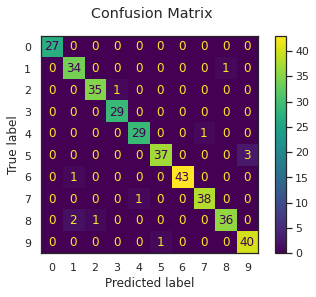

In [ ]:
disp = metrics.plot_confusion_matrix(lr, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

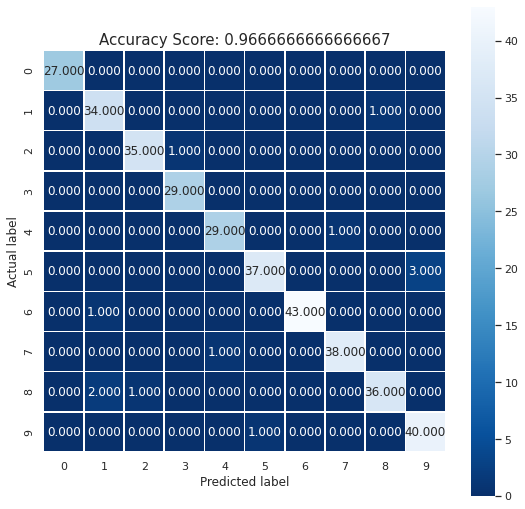

In [ ]:
cm = metrics.confusion_matrix(y_test, predictions)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
#plt.show();